## **1. Download dataset**
!gdown --id 1e1uIwcJ1-MviSn9yk_ldPGffDWVp6yK_
!unzip twitter_sentiment_analysis_3cls_dataset.zip

## **2. Import libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import torch
import torch.nn as nn
import torch.optim as optim
import nltk
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chaum\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **3. Read dataset**

In [3]:
dataset_path = 'Twitter_Data.csv'
df = pd.read_csv(
    filepath_or_buffer=dataset_path
)
df

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


## **4. Drop missing value**

In [5]:
null_rows = df.isnull().any(axis=1)
df[null_rows]

,clean_text,category
148,NaN,0.0
130448,the foundation stone northeast gas grid inaugu...,NaN
155642,dear terrorists you can run but you cant hide ...,NaN
155698,offense the best defence with mission shakti m...,NaN
155770,have always heard politicians backing out thei...,NaN
158693,modi government plans felicitate the faceless ...,NaN
158694,NaN,-1.0
159442,chidambaram gives praises modinomics,NaN
159443,NaN,0.0
160559,the reason why modi contested from seats 2014 ...,NaN


In [6]:
df = df.dropna()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162969 non-null  object 
 1   category    162969 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.7+ MB


## **5. Preprocessing data**



In [8]:
def text_normalize(text):
    # Lowercasing
    text = text.lower()
    
    # Remove retweet old acronym "RT"
    text = re.sub(r'rt[\s]+', '', text)
    
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    # Stemming
    stemmer = SnowballStemmer('english')
    words = text.split()
    words = [stemmer.stem(word) for word in words]
    
    # Join words back into a single string
    text = ' '.join(words)
    
    return text

In [9]:
df['clean_text'] = df['clean_text'].apply(lambda x: text_normalize(x))

C:\Users\chaum\AppData\Local\Temp\ipykernel_4308\2442437572.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['clean_text'].apply(lambda x: text_normalize(x))


In [10]:
df

,clean_text,category
0,when modi promis minimum govern maximum govern...,-1.0
1,talk all the nonsens and continu all the drama...,0.0
2,what did just say vote for modi welcom bjp tol...,1.0
3,ask his support prefix chowkidar their name mo...,1.0
4,answer who among these the most power world le...,1.0
...,...,...
162975,whi these 456 crore paid neerav modi not recov...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interact forum where she left,0.0
162978,there big project came into india modi dream p...,0.0


## **6. One-hot encoding label**

In [11]:
n_classes = df['category'].nunique()
n_samples = df['category'].shape[0]
print(f'Number of classes: {n_classes}')
print(f'Number of samples: {n_samples}')

y = (df['category'].to_numpy() + 1).astype(np.uint8)
y_encoded = np.array(
    [np.zeros(n_classes) for _ in range(n_samples)]
)
y_encoded[np.arange(n_samples), y] = 1
print(f'Shape of y_encoded: {y_encoded.shape}')

Number of classes: 3
Number of samples: 162969
Shape of y_encoded: (162969, 3)


## **7. Create train, val, test set**

In [12]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

x_train, x_val, y_train, y_val = train_test_split(
    df['clean_text'], y_encoded,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

x_train, x_test, y_train, y_test = train_test_split(
    x_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

## **8. Tf-idf vectorizer**

In [13]:
vectorizer = TfidfVectorizer(max_features=2000)
x_train = vectorizer.fit_transform(x_train).toarray()
x_val = vectorizer.transform(x_val).toarray()
x_test = vectorizer.transform(x_test).toarray()

In [14]:
x_train = np.concatenate(
    (np.ones((x_train.shape[0], 1)), x_train), 
    axis=1)

x_val = np.concatenate(
    (np.ones((x_val.shape[0], 1)), x_val), 
    axis=1)

x_test = np.concatenate(
    (np.ones((x_test.shape[0], 1)), x_test), 
    axis=1)

## **9. Define Softmax Regression model**

In [19]:
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [20]:
class SoftmaxRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SoftmaxRegression, self).__init__()
        self.linear = nn.Linear(
            input_dim,
            output_dim,
            bias=True
        )

    def forward(self, x):
        return self.linear(x)

In [25]:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    _, y_true = torch.max(y_true, dim=1)
    
    return (y_hat == y_true).sum().item() / len(y_true)

## **10. Training**

In [26]:
lr = 0.1
epochs = 500
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

input_dim = x_train.shape[1]
output_dim = y_train.shape[1]

model = SoftmaxRegression(
    input_dim, output_dim
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(), lr=lr
)

In [27]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(epochs):
    model.train()

    # Forward pass
    y_hat = model(x_train)

    # Compute loss and accuracy
    train_loss = criterion(y_hat, y_train)
    train_losses.append(train_loss.item())
    train_accs.append(compute_accuracy(y_hat, y_train))

    # Backward pass and optimization
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        y_val_hat = model(x_val)

        # Compute validation loss and accuracy
        val_loss = criterion(y_val_hat, y_val)
        val_losses.append(val_loss.item())
        val_accs.append(compute_accuracy(y_val_hat, y_val))

    print(f'\nEpoch {epoch + 1}/{epochs} | Training Loss: {train_losses[-1]:.3f} | Validation Loss: {val_losses[-1]:.3f}')


Epoch 1/500 | Training Loss: 1.100 | Validation Loss: 1.094

Epoch 2/500 | Training Loss: 1.095 | Validation Loss: 1.090

Epoch 3/500 | Training Loss: 1.090 | Validation Loss: 1.086

Epoch 4/500 | Training Loss: 1.086 | Validation Loss: 1.082

Epoch 5/500 | Training Loss: 1.083 | Validation Loss: 1.079

Epoch 6/500 | Training Loss: 1.080 | Validation Loss: 1.077

Epoch 7/500 | Training Loss: 1.077 | Validation Loss: 1.074

Epoch 8/500 | Training Loss: 1.075 | Validation Loss: 1.072

Epoch 9/500 | Training Loss: 1.073 | Validation Loss: 1.070

Epoch 10/500 | Training Loss: 1.071 | Validation Loss: 1.069

Epoch 11/500 | Training Loss: 1.070 | Validation Loss: 1.067

Epoch 12/500 | Training Loss: 1.068 | Validation Loss: 1.066

Epoch 13/500 | Training Loss: 1.067 | Validation Loss: 1.065

Epoch 14/500 | Training Loss: 1.066 | Validation Loss: 1.064

Epoch 15/500 | Training Loss: 1.065 | Validation Loss: 1.063

Epoch 16/500 | Training Loss: 1.065 | Validation Loss: 1.062

Epoch 17/500 | T

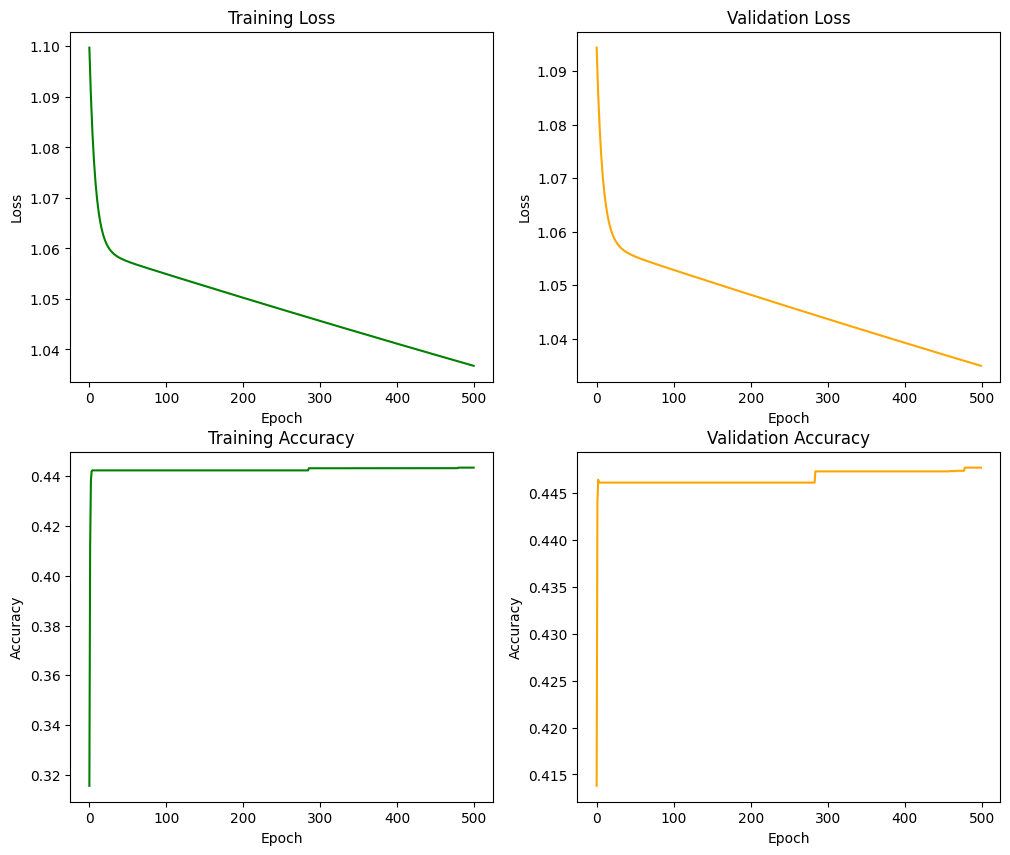

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## **11. Evaluation**

In [29]:
# Val set
model.eval()
with torch.no_grad():
    y_hat = model(x_val)
    val_set_acc = compute_accuracy(y_hat, y_val)
    print('Evaluation on validation set:')
    print(f'Accuracy: {val_set_acc}')

Evaluation on validation set:
Accuracy: 0.44772043934466466


In [30]:
# Test set
model.eval()
with torch.no_grad():
    y_hat = model(x_test)
    test_set_acc = compute_accuracy(y_hat, y_test)
    print('Evaluation on test set:')
    print(f'Accuracy: {test_set_acc}')

Evaluation on test set:
Accuracy: 0.446646622077683
